# 5. CNN2

## 5-1. 이미지 분류
> 특정 대상이 영상(이미지) 내에 존재하는지 판단

### 5-1-1. LeNet-5
![LeNet5](https://i.imgur.com/tQGDtMp.jpg)
- MNIST
- 합성곱(Conv)과 다운 샘플링(sub-sampling)

| Layer Type | Ftr Map | Size | Kernel | Stride | Act. |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 이미지 | 1 | 32*32 | - | - | - |
| 합성곱 | 6 | 28*28 | 5*5 | 1 | ReLU |
| 최대 풀링 | 6 | 14*14 | 2*2 | 2 | - |
| 합성곱 | 16 | 10*10 | 5*5 | 1 | ReLU |
| 최대 풀링 | 16 | 5*5 | 2*2 | 2 | - |
| FC | - | 120 | - | - | ReLU |
| FC | - | 84 | - | - | ReLU |
| FC | - | 2 | - | - | Softmax |

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import time
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform ={
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# Kaggle Train-Test 통합
cat_dir = r"../data/catanddog/Cat/"
dog_dir = r"../data/catanddog/Dog/"
#
cat_img_filepaths = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_img_filepaths = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
image_filepaths = [*cat_img_filepaths, *dog_img_filepaths]
correct_images_filepaths = [i for i in image_filepaths if cv2.imread(i) is not None]
#
print(len(image_filepaths))
print(len(correct_images_filepaths))

483
483


In [4]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 73 10


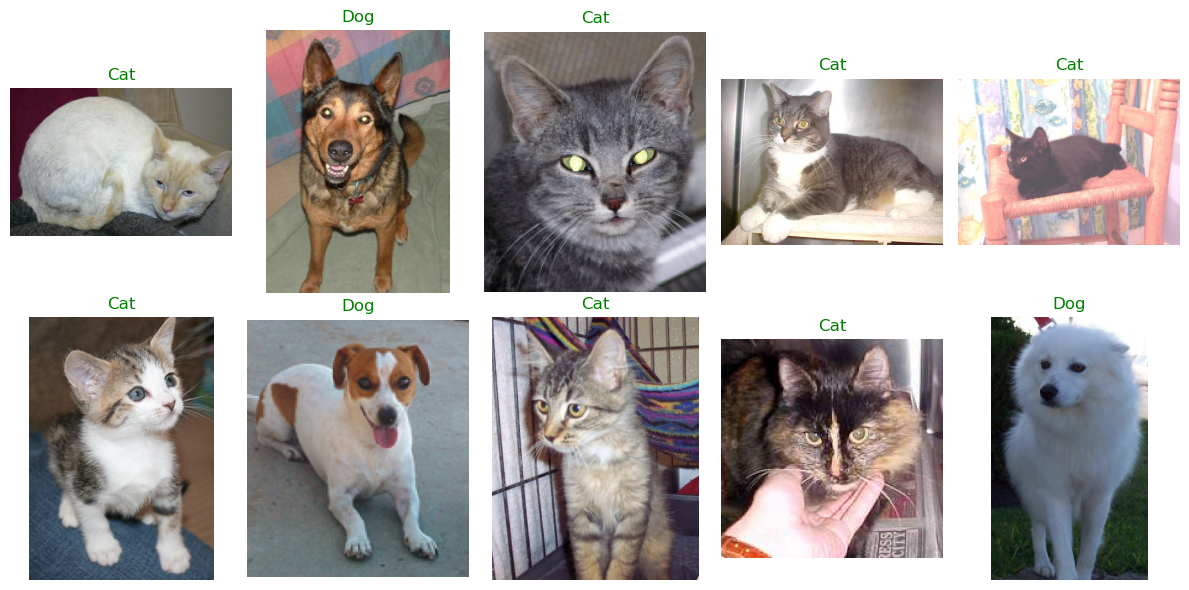

In [5]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths)//cols
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label==predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
#
display_image_grid(test_images_filepaths)

In [53]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = train_images_filepaths[0].split("/")[-2].lower()
        if label=="dog": label=1
        else: label=0
        return img_transformed, label

In [54]:
CFG = {
    "SIZE":224,
    "MEAN":(0.485, 0.456, 0.406),
    "STD":(0.229, 0.224, 0.225),
    "BATCH_SIZE":32
}

In [55]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(CFG["SIZE"], CFG["MEAN"], CFG["STD"]), phase="train")
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(CFG["SIZE"], CFG["MEAN"], CFG["STD"]), phase="val")

idx=0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])

torch.Size([3, 224, 224])
1


In [56]:
train_dataloader = DataLoader(train_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False)
dataloader_dict = {"train":train_dataloader, "val":val_dataloader}
#
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [57]:
# LeNet-5
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out
        
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [58]:
# 학습 가능한 파라미터 수
def count_parameters(models):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{count_parameters(model):,}")

46,038,242


In [59]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
#
model = model.to(device)
criterion = criterion.to(device)
#
def train_moel(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1}/{num_epoch}")
        print("-"*20)
        for phase in ["train", "val"]:
            if phase=="train": model.train()
            else: model.eval()
            epoch_loss, epoch_corrects = 0.0, 0.0
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    _, preds = torch.max(torch.tensor(outputs), dim=1)
                    loss = criterion(outputs, labels)
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase=="val" and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    time_elapsed = time.time() - since
    print(f"Training Complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}")
    print(f"Best val Acc: {best_acc:.4f}")
    return model

In [60]:
epochs = 10
model = train_moel(model, dataloader_dict, criterion, optimizer, epochs)

Epoch 1/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]C:\Users\nuyhc\AppData\Local\Temp\ipykernel_27964\1039798194.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, preds = torch.max(torch.tensor(outputs), dim=1)
100%|██████████| 13/13 [00:01<00:00, 10.79it/s]


train Loss: 0.3837 Acc: 0.9425


100%|██████████| 3/3 [00:00<00:00, 16.65it/s]


val Loss: 0.3134 Acc: 1.0000
Epoch 2/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.79it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 15.64it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 3/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.46it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.12it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 4/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.16it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.60it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 5/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.47it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.47it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 6/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.17it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 15.69it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 7/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.46it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.58it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 8/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.17it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.69it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 9/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.47it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.42it/s]


val Loss: 0.3133 Acc: 1.0000
Epoch 10/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.53it/s]


train Loss: 0.3133 Acc: 1.0000


100%|██████████| 3/3 [00:00<00:00, 16.40it/s]

val Loss: 0.3133 Acc: 1.0000
Training Complete in 0m 14
Best val Acc: 1.0000


In [61]:
# Validate
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[0]
        transform = ImageTransform(CFG["SIZE"], CFG["MEAN"], CFG["STD"])
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

100%|██████████| 10/10 [00:00<00:00, 108.49it/s]


In [62]:
res

,id,label
0,2,0.731058
1,31,0.730957
2,56,0.731059
3,60,0.731059
4,7549,0.731053
5,7592,0.731059
6,7603,0.731059
7,7618,0.731059
8,8113,0.731055
9,8115,0.731054


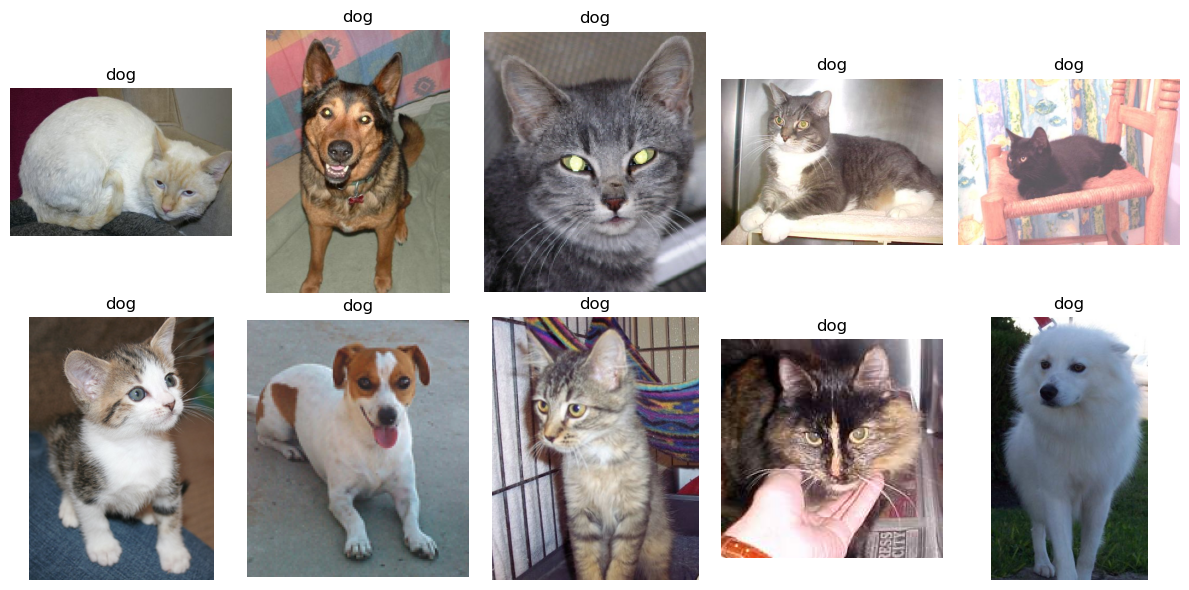

In [63]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths) 

### 5-1-2. AlexNet
> ILSVRC 2012 
- GPU1 = Color X, GPU2 = Color O


![AlexNet](https://t1.daumcdn.net/cfile/tistory/99FEB93C5C80B5192E)

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
               transforms.Resize(256),
               transforms.CenterCrop(resize),
               transforms.ToTensor(),
               transforms.Normalize(mean, std) 
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [8]:
cat_dir = "../data/dogs-vs-cats/Cat/"
dog_dir = "../data/dogs-vs-cats/Dog/"
#
cat_images_filepaths = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_images_filepaths = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
#
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [9]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        #
        label = img_path.split("/")[-1].split(".")[0]
        if label=="dog": label=1
        else: label=0
        #
        return img_transformed, label

In [10]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [11]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase="train")
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase="val")
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase="val")
#
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])

torch.Size([3, 256, 256])
0


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}
#
batch_iterator = iter(train_dataloader)
inputs, outputs = next(batch_iterator)
print(inputs.size())
print(outputs)

torch.Size([32, 3, 256, 256])
tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 0])


In [16]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, padding=1),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [17]:
model = AlexNet()
model = model.to(device)

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [19]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 11, 11]               0
            Conv2d-7          [-1, 384, 11, 11]         663,936
              ReLU-8          [-1, 384, 11, 11]               0
            Conv2d-9          [-1, 256, 11, 11]         884,992
             ReLU-10          [-1, 256, 11, 11]               0
           Conv2d-11          [-1, 256, 11, 11]         590,080
             ReLU-12          [-1, 256, 11, 11]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
AdaptiveAvgPool2d-14            [-1, 25

In [22]:
import time
def train_model(model, dataloader_dict, criterion, optimizer, epochs):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print("-"*20)
        #
        for phase in ["train", "val"]:
            if phase=="train": model.train()
            else: model.eval()
            #
            epoch_loss = 0.0
            epoch_corrects = 0
            #
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                #
                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #
                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
            #
            epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    return model

In [23]:
epochs = 10
model = train_model(model, dataloader_dict, criterion, optimizer, epochs)

Epoch 1/10
--------------------


100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


train Loss: 0.6936 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 11.86it/s]


val Loss: 0.6939 Acc: 0.4891
Epoch 2/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.94it/s]


train Loss: 0.6935 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.77it/s]


val Loss: 0.6938 Acc: 0.4891
Epoch 3/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.73it/s]


train Loss: 0.6929 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.50it/s]


val Loss: 0.6937 Acc: 0.4891
Epoch 4/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.81it/s]


train Loss: 0.6933 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.75it/s]


val Loss: 0.6935 Acc: 0.4891
Epoch 5/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 11.30it/s]


train Loss: 0.6933 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.70it/s]


val Loss: 0.6934 Acc: 0.4891
Epoch 6/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 11.33it/s]


train Loss: 0.6932 Acc: 0.4975


100%|██████████| 3/3 [00:00<00:00, 12.78it/s]


val Loss: 0.6933 Acc: 0.4891
Epoch 7/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.99it/s]


train Loss: 0.6932 Acc: 0.5025


100%|██████████| 3/3 [00:00<00:00, 12.68it/s]


val Loss: 0.6933 Acc: 0.4891
Epoch 8/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.45it/s]


train Loss: 0.6931 Acc: 0.5025


100%|██████████| 3/3 [00:00<00:00, 12.53it/s]


val Loss: 0.6932 Acc: 0.4891
Epoch 9/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.66it/s]


train Loss: 0.6930 Acc: 0.5000


100%|██████████| 3/3 [00:00<00:00, 12.72it/s]


val Loss: 0.6931 Acc: 0.4891
Epoch 10/10
--------------------


100%|██████████| 13/13 [00:01<00:00, 10.77it/s]


train Loss: 0.6930 Acc: 0.5300


100%|██████████| 3/3 [00:00<00:00, 12.65it/s]

val Loss: 0.6929 Acc: 0.5109
Training complete in 0m 15s


In [25]:
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split("/")[-1].split(".")[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase="val")
        img = img.unsqueeze(0)
        img = img.to(device)
        #
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        #
        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    "id":id_list,
    "label":pred_list
})

res.head(10)

100%|██████████| 10/10 [00:00<00:00, 44.67it/s]


,id,label
0,145,0.498823
1,211,0.499402
2,162,0.499027
3,200,0.500486
4,210,0.499889
5,224,0.498975
6,213,0.498723
7,109,0.500269
8,15,0.499252
9,167,0.498490


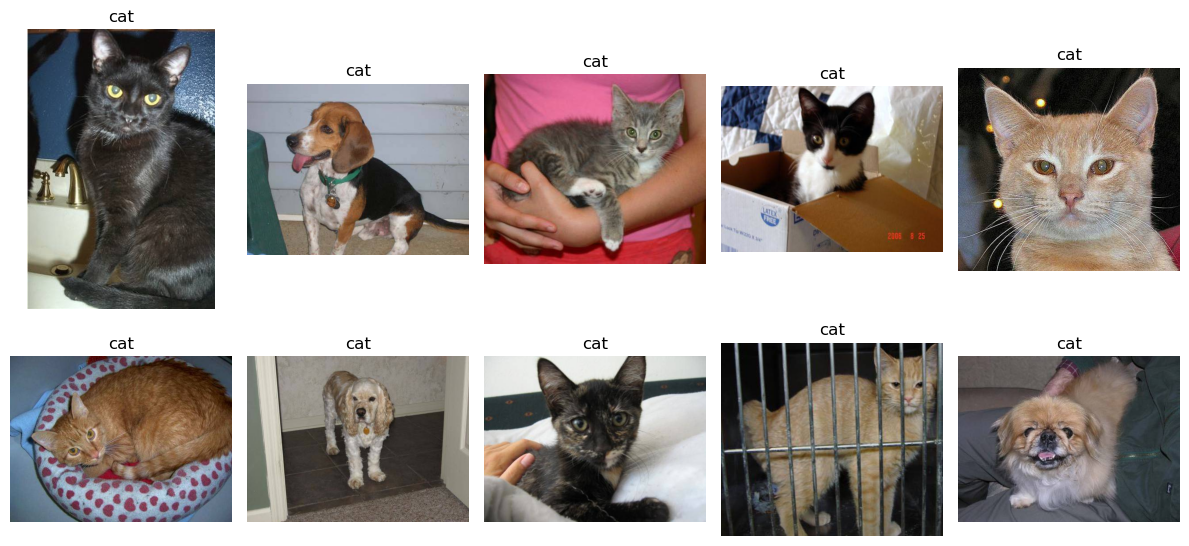

In [27]:
import matplotlib.pyplot as plt

class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
display_image_grid(test_images_filepaths)

### 5-1-3. VGGNet
> Conv의 필터/커널 크기를 3X3으로 고정

![VGG16](https://miro.medium.com/v2/resize:fit:857/1*AqqArOvacibWqeulyP_-8Q.png)

### 5-1-4. ResNet ★
- 신경망의 깊이가 깊어지면 깊어질수록, 성능이 좋아지다가 일정한 단계에 이르면 성능이 나빠짐
- 레지듀얼 블록(residual block) 도입 -> 기울기 전파를 위한 숏컷(shortcut)

## 5-2. 객체 인식

## 5-3. 이미지 분할